# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
# !pip install tensorflow-gpu==2.10
# !pip install tensorflow==2.10.0


In [ ]:
# !pip install labelme opencv-python matplotlib albumentations

In [14]:
!git clone "https://github.com/Darsh377/DeepFace.git"

Cloning into 'DeepFace'...
remote: Enumerating objects: 17916, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 17916 (delta 0), reused 69 (delta 0), pack-reused 17846
Receiving objects: 100% (17916/17916), 414.26 MiB | 41.38 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (18459/18459), done.


In [15]:
cd DeepFace

/content/DeepFace


### 1.2 Collect Images Using OpenCV

In [16]:
import os
import time
import uuid
import cv2

In [17]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [18]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [19]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [20]:
# !pip install labelme

In [21]:
# !labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [22]:
# !pip install "tensorflow<2.11"

In [23]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [26]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [29]:
images = tf.data.Dataset.list_files('/content/DeepFace/data/images/*.jpg')

In [30]:
images.as_numpy_iterator().next()

b'/content/DeepFace/data/images/57e0e129-eb76-11ee-941b-b0a460a7153d.jpg'

In [31]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [32]:
images = images.map(load_image)

array([[[ 36,  23,  41],
        [ 36,  23,  40],
        [ 35,  22,  39],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 33,  20,  38],
        [ 34,  21,  38],
        [ 34,  22,  36],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 33,  22,  38],
        [ 33,  22,  38],
        [ 33,  22,  36],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 47,  49,  38],
        [ 50,  52,  41],
        [ 53,  55,  44],
        ...,
        [ 81,  94,  68],
        [ 80,  93,  67],
        [ 79,  92,  66]],

       [[ 47,  47,  37],
        [ 50,  50,  40],
        [ 53,  53,  43],
        ...,
        [ 83,  98,  69],
        [ 83,  98,  69],
        [ 82,  97,  68]],

       [[ 47,  47,  37],
        [ 49,  49,  39],
        [ 51,  51,  41],
        ...,
        [ 80,  95,  66],
        [ 80,  95,  64],
        [ 79,  94,  63]]], dtype=uint8)
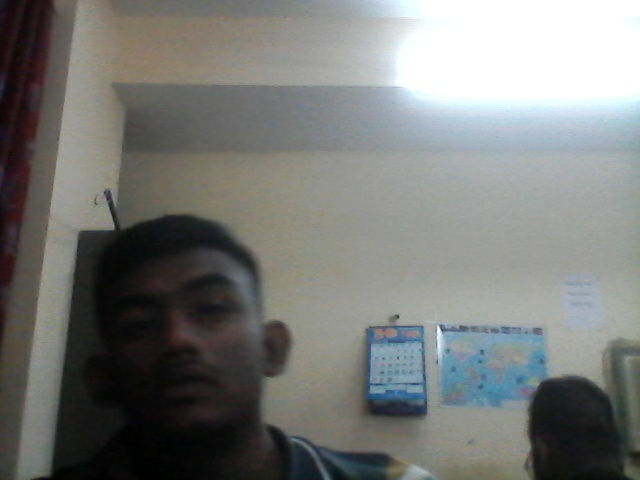

In [33]:
images.as_numpy_iterator().next()

In [34]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [35]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_images = image_generator.next()

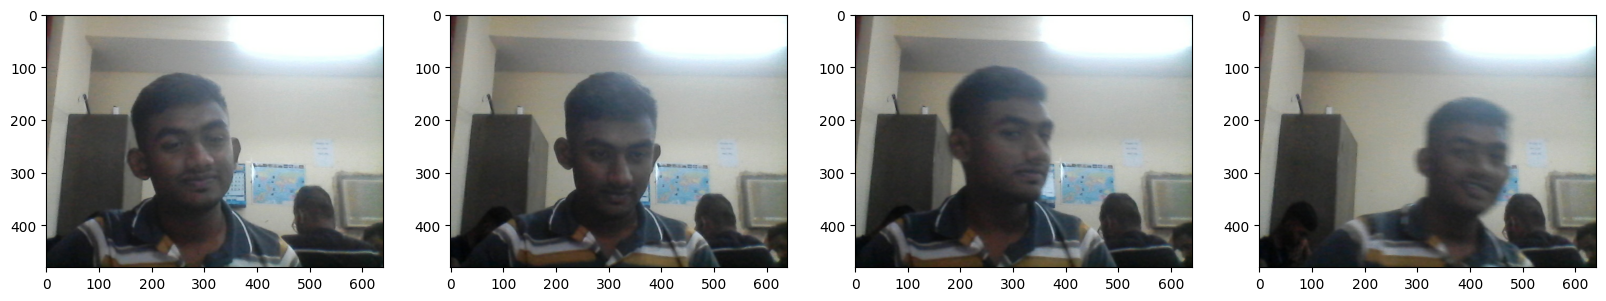

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [38]:
90*.7 # 63 to train

62.99999999999999

In [39]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [40]:
import os

In [41]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [42]:
import albumentations as alb

In [43]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [44]:
img = cv2.imread(os.path.join('data','train', 'images','0d75554e-eb76-11ee-9035-b0a460a7153d.jpg'))

In [45]:
with open(os.path.join('data', 'train', 'labels', '0d75554e-eb76-11ee-9035-b0a460a7153d.json'), 'r') as f:
    label = json.load(f)

In [46]:
label['shapes'][0]['points']

[[133.10679611650488, 66.69902912621362],
 [436.0194174757282, 400.67961165048547]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [47]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [48]:
coords

[133.10679611650488, 66.69902912621362, 436.0194174757282, 400.67961165048547]

In [49]:
coords = list(np.divide(coords, [640,480,640,480]))

In [50]:
coords

[0.2079793689320389,
 0.1389563106796117,
 0.6812803398058253,
 0.8347491909385114]

### 4.4 Apply Augmentations and View Results

In [51]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [52]:
augmented['bboxes'][0][2:]

(0.9686515641855447, 0.8695577130528587)

In [53]:
augmented['bboxes']

[(0.295512405609493,
  0.12737864077669891,
  0.9686515641855447,
  0.8695577130528587)]

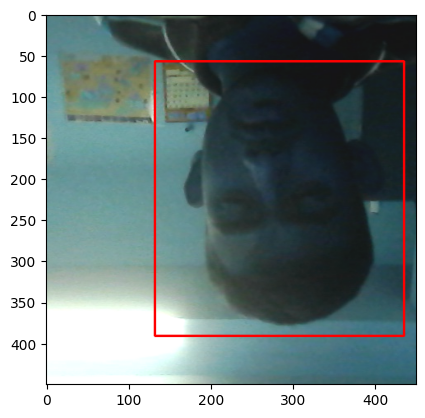

In [54]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [55]:
# for partition in ['train','test','val']:
#     for image in os.listdir(os.path.join('data', partition, 'images')):
#         img = cv2.imread(os.path.join('data', partition, 'images', image))

#         coords = [0,0,0.00001,0.00001]
#         label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             coords[0] = label['shapes'][0]['points'][0][0]
#             coords[1] = label['shapes'][0]['points'][0][1]
#             coords[2] = label['shapes'][0]['points'][1][0]
#             coords[3] = label['shapes'][0]['points'][1][1]
#             coords = list(np.divide(coords, [640,480,640,480]))

#         try:
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
#                 cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

#                 annotation = {}
#                 annotation['image'] = image

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0,0,0,0]
#                         annotation['class'] = 0
#                     else:
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
#                 else:
#                     annotation['bbox'] = [0,0,0,0]
#                     annotation['class'] = 0


#                 with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [56]:
# import tensorflow as tf
# import cv2

# def load_and_preprocess_image(file_path):
#     # Load the image
#     image = tf.io.read_file(file_path)
#     image = tf.image.decode_jpeg(image, channels=3)

#     # Resize the image to (120, 120)
#     image = tf.image.resize(image, [120, 120])

#     # Normalize the pixel values to [0, 1]
#     image = tf.cast(image, tf.float32) / 255.0

#     return image

# # Define batch size
# batch_size = 32

# # Create a dataset of file paths
# file_paths_dataset = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)

# # Map the load_and_preprocess_image function to each file path
# train_images = file_paths_dataset.map(load_and_preprocess_image)

# # Shuffle and batch the dataset
# train_images = train_images.shuffle(buffer_size=1000).batch(batch_size)

# # Prefetch the dataset for better performance
# train_images = train_images.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# # Example usage
# for image_batch in train_images.take(1):
#     print(image_batch.shape)


In [58]:
train_images = tf.data.Dataset.list_files('/content/DeepFace/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
# import tensorflow as tf
# import cv2

# def load_and_preprocess_image(image_path):
#     # Load the image
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)

#     # Resize the image to (120, 120)
#     image = tf.image.resize(image, [120, 120])

#     # Normalize the pixel values to [0, 1]
#     image = tf.cast(image, tf.float32) / 255.0

#     return image

# # Create a dataset of file paths
# test_file_paths_dataset = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)

# # Map the load_and_preprocess_image function to each file path
# test_images = test_file_paths_dataset.map(load_and_preprocess_image)

# # Example usage
# for image in test_images.take(1):
#     print(image.shape)


In [60]:
test_images = tf.data.Dataset.list_files('/content/DeepFace/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
# import tensorflow as tf
# import cv2

# def load_and_preprocess_image(image_path):
#     # Ensure image_path is a string tensor
#     image_path_str = tf.strings.reduce_join(image_path)

#     # Load the image
#     image = tf.io.read_file(image_path_str)
#     image = tf.image.decode_jpeg(image, channels=3)

#     # Resize the image to (120, 120)
#     image = tf.image.resize(image, [120, 120])

#     # Normalize the pixel values to [0, 1]
#     image = tf.cast(image, tf.float32) / 255.0

#     return image

# # Create a dataset of file paths
# val_file_paths_dataset = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)

# # Map the load_and_preprocess_image function to each file path
# val_images = val_file_paths_dataset.map(load_and_preprocess_image)

# # Example usage
# for image in val_images.take(1):
#     print(image.shape)


In [62]:
val_images = tf.data.Dataset.list_files('/content/DeepFace/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [63]:
train_images.as_numpy_iterator().next()

array([[[0.21819852, 0.14595588, 0.0651348 ],
        [0.2632353 , 0.18529412, 0.07794118],
        [0.29460785, 0.21715686, 0.09313726],
        ...,
        [0.98204654, 0.9970588 , 0.93302697],
        [0.9836397 , 0.9983456 , 0.9346201 ],
        [0.97990197, 0.9988971 , 0.9327206 ]],

       [[0.2254902 , 0.15588236, 0.06617647],
        [0.2553309 , 0.18872549, 0.06960785],
        [0.27438724, 0.21121323, 0.08131128],
        ...,
        [0.9637255 , 0.9911765 , 0.8677083 ],
        [0.97107846, 0.99852943, 0.8750613 ],
        [0.96139705, 0.99313724, 0.8678309 ]],

       [[0.20373775, 0.14883578, 0.0432598 ],
        [0.23596814, 0.19313726, 0.06623775],
        [0.27022058, 0.23082107, 0.09362745],
        ...,
        [0.9716299 , 0.9990809 , 0.86966914],
        [0.9794118 , 1.        , 0.877451  ],
        [0.97971815, 0.9957108 , 0.8715686 ]],

       ...,

       [[0.09411765, 0.08658088, 0.02941176],
        [0.0627451 , 0.05435049, 0.00821078],
        [0.06568628, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [64]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [67]:
train_labels = tf.data.Dataset.list_files('/content/DeepFace/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [68]:
test_labels = tf.data.Dataset.list_files('/content/DeepFace/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [70]:
val_labels = tf.data.Dataset.list_files('/content/DeepFace/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [71]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.178  , 0.11487, 0.851  , 0.857  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [72]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5400, 5400, 1800, 1800, 1800, 1800)

### 7.2 Create Final Datasets (Images/Labels)

In [73]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [74]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [75]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [76]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.182  , 0.1887 , 0.894  , 0.8296 ],
        [0.1255 , 0.1632 , 0.7207 , 0.9336 ],
        [0.     , 0.4026 , 0.4475 , 1.     ],
        [0.476  , 0.1032 , 1.     , 0.6147 ],
        [0.07806, 0.     , 0.7124 , 0.6    ],
        [0.2566 , 0.04553, 0.8154 , 0.6216 ],
        [0.2534 , 0.1274 , 0.9287 , 0.8457 ],
        [0.1128 , 0.0902 , 0.6997 , 0.774  ]], dtype=float16))

7.3 View Images and Annotations

In [77]:
data_samples = train.as_numpy_iterator()

In [78]:
res = data_samples.next()

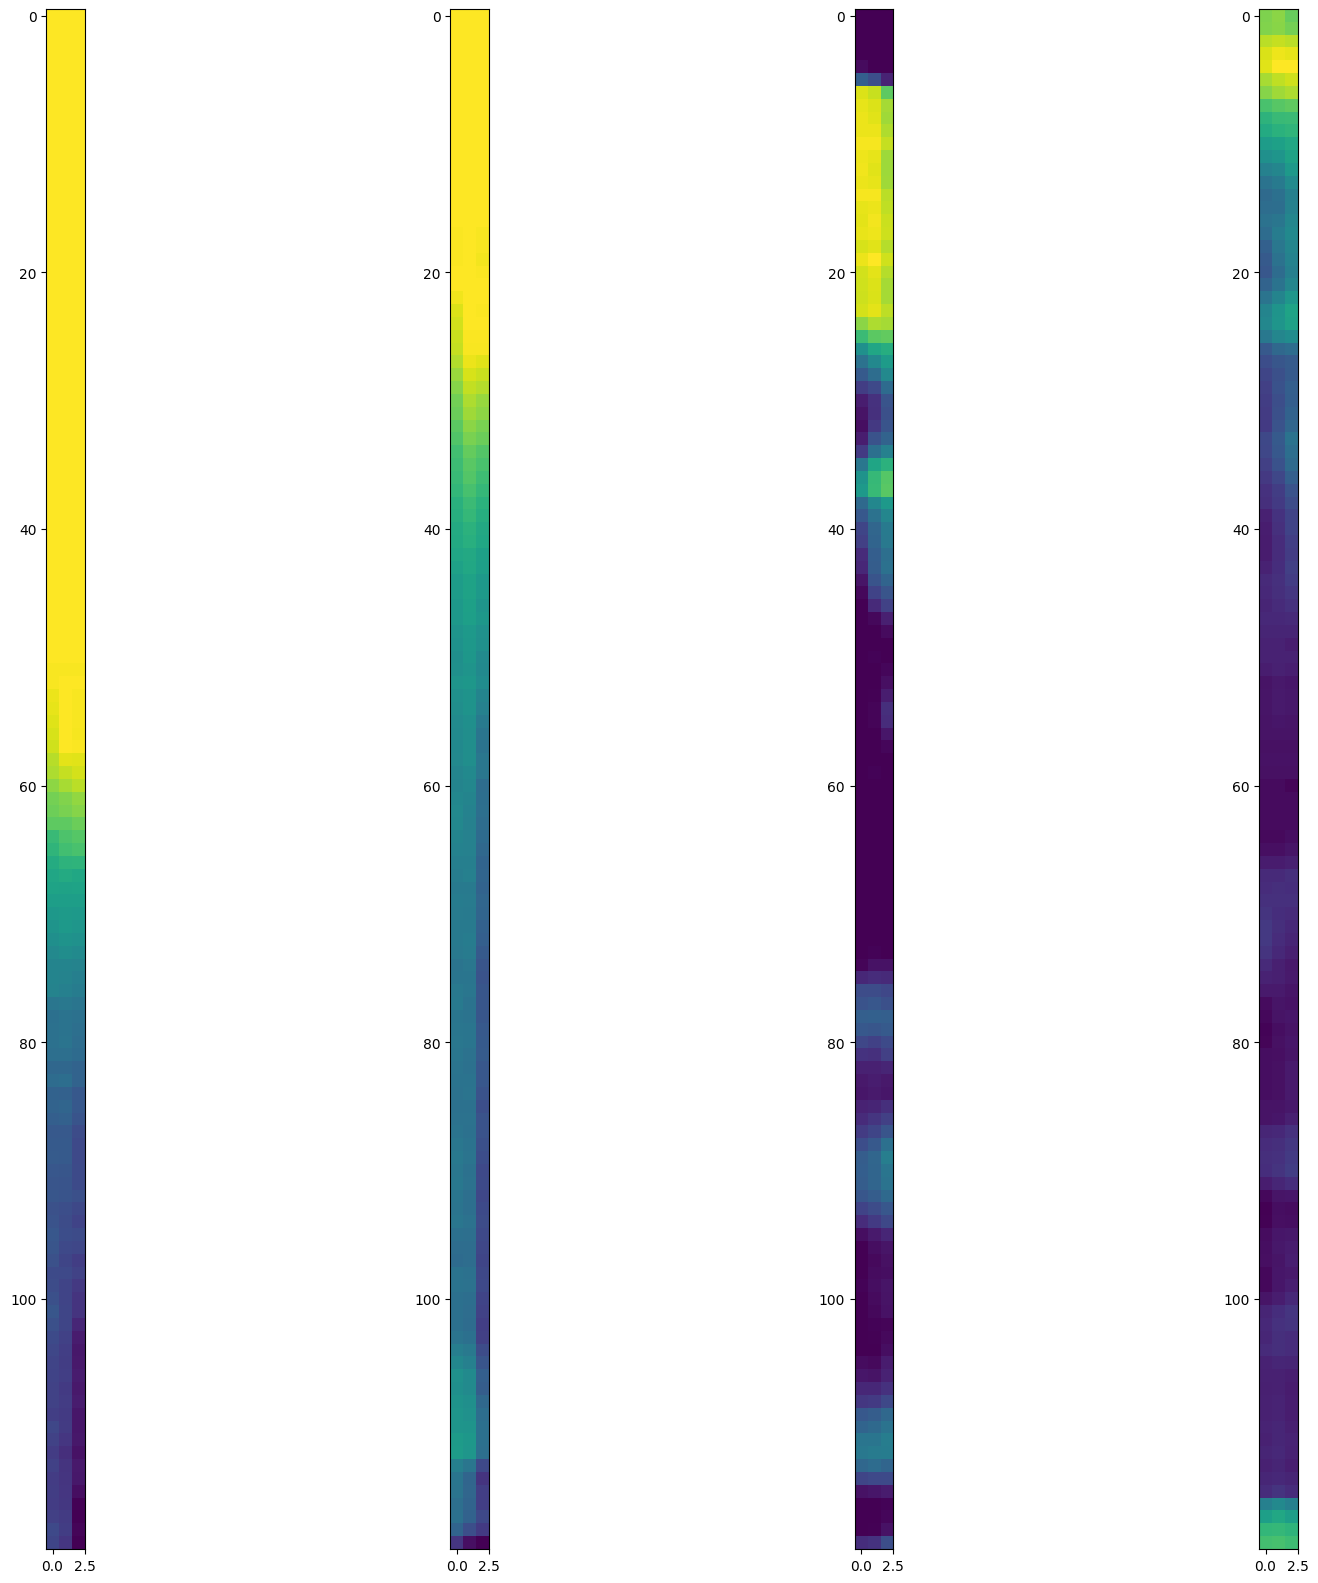

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image_um = cv2.UMat(sample_image)

    cv2.rectangle(sample_image_um,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    sample_image_with_rect = sample_image_um.get()

    # Display the image in the current subplot
    ax[idx].imshow(sample_image_with_rect[0])  # Assuming you want to display the first image from the batch


In [80]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx in range(4):
#     sample_image = res[0][idx]
#     sample_coords = res[1][1][idx]

#     cv2.rectangle(sample_image,
#                   tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                   tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
#                         (255,0,0), 2)

#     ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [82]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [83]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [84]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [85]:
facetracker = build_model()

In [86]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [87]:
X, y = train.as_numpy_iterator().next()

In [88]:
X.shape

(8, 120, 120, 3)

In [89]:
# Assuming X has shape (None, 32, 120, 120, 3)
# Reshape X to remove the extra dimension
X = X.reshape(-1, 120, 120, 3)

# Now, you can predict using the reshaped input
classes, coords = facetracker.predict(X)


1/1 [==============================] - 3s 3s/step


In [90]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 23ms/step


In [91]:
classes, coords

(array([[0.44783255],
        [0.44895104],
        [0.5131767 ],
        [0.46482584],
        [0.47660688],
        [0.48921946],
        [0.40774035],
        [0.53319174]], dtype=float32),
 array([[0.38580444, 0.55399007, 0.30095994, 0.47625148],
        [0.4072682 , 0.57587254, 0.30825835, 0.4447569 ],
        [0.438252  , 0.56995827, 0.38911748, 0.4878897 ],
        [0.43910557, 0.5381297 , 0.32413813, 0.4538314 ],
        [0.52589583, 0.58573717, 0.3929267 , 0.49039438],
        [0.48292187, 0.55742776, 0.32516637, 0.463155  ],
        [0.42629087, 0.6058531 , 0.28648645, 0.42737836],
        [0.46001938, 0.5847768 , 0.37019965, 0.46814993]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [92]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [102]:
# Import necessary libraries
import tensorflow as tf

# Define the optimizer with the legacy Adam class
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

# Rest of the code remains the same

### 9.2 Create Localization Loss and Classification Loss

In [103]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [104]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [105]:
localization_loss(y[1],coords).numpy()

9.097656

In [106]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.747035>

In [107]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.097656>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [108]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [109]:
model = FaceTracker(facetracker)

In [110]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [111]:
logdir='logs'

In [112]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [113]:
hist = model.fit(train, epochs=10, validation_data=val,verbose=2, callbacks=[tensorboard_callback])

Epoch 1/10
675/675 - 57s - total_loss: 0.1061 - class_loss: 1.5077e-04 - regress_loss: 0.1060 - val_total_loss: 1.3067 - val_class_loss: 0.6251 - val_regress_loss: 0.9942 - 57s/epoch - 85ms/step
Epoch 2/10
675/675 - 51s - total_loss: 0.0691 - class_loss: 3.5884e-05 - regress_loss: 0.0691 - val_total_loss: 0.2380 - val_class_loss: 0.0010 - val_regress_loss: 0.2374 - 51s/epoch - 76ms/step
Epoch 3/10
675/675 - 52s - total_loss: 0.0209 - class_loss: 1.6645e-05 - regress_loss: 0.0209 - val_total_loss: 0.5751 - val_class_loss: 0.0173 - val_regress_loss: 0.5665 - 52s/epoch - 77ms/step
Epoch 4/10
675/675 - 52s - total_loss: 0.0343 - class_loss: 3.4080e-05 - regress_loss: 0.0343 - val_total_loss: 0.1398 - val_class_loss: 0.0022 - val_regress_loss: 0.1387 - 52s/epoch - 77ms/step
Epoch 5/10
675/675 - 56s - total_loss: 0.0157 - class_loss: 1.1519e-05 - regress_loss: 0.0156 - val_total_loss: 2.3830 - val_class_loss: 1.9281 - val_regress_loss: 1.4189 - 56s/epoch - 83ms/step
Epoch 6/10
675/675 - 52s 

### 10.3 Plot Performance

In [114]:
hist.history

{'total_loss': [0.10611458122730255,
  0.06909780949354172,
  0.0209177378565073,
  0.03431516885757446,
  0.015651995316147804,
  0.015625229105353355,
  0.007173529826104641,
  0.009109455160796642,
  0.005916156806051731,
  0.004885462578386068],
 'class_loss': [0.00015077338321134448,
  3.5883811506209895e-05,
  1.6644864444970153e-05,
  3.4079886972904205e-05,
  1.151870583271375e-05,
  2.7315525585436262e-05,
  7.659298717044294e-06,
  4.9018995923688635e-05,
  8.165950021066237e-06,
  5.826390861329855e-06],
 'regress_loss': [0.10603919625282288,
  0.06907986849546432,
  0.020909415557980537,
  0.0342981293797493,
  0.015646236017346382,
  0.01561157125979662,
  0.007169700227677822,
  0.009084945544600487,
  0.005912073887884617,
  0.004882549401372671],
 'val_total_loss': [1.3067381381988525,
  0.2379658818244934,
  0.5750994086265564,
  0.1397857964038849,
  2.382952928543091,
  2.0309364795684814,
  0.09792619943618774,
  1.5503548383712769,
  1.210275411605835,
  0.13119050

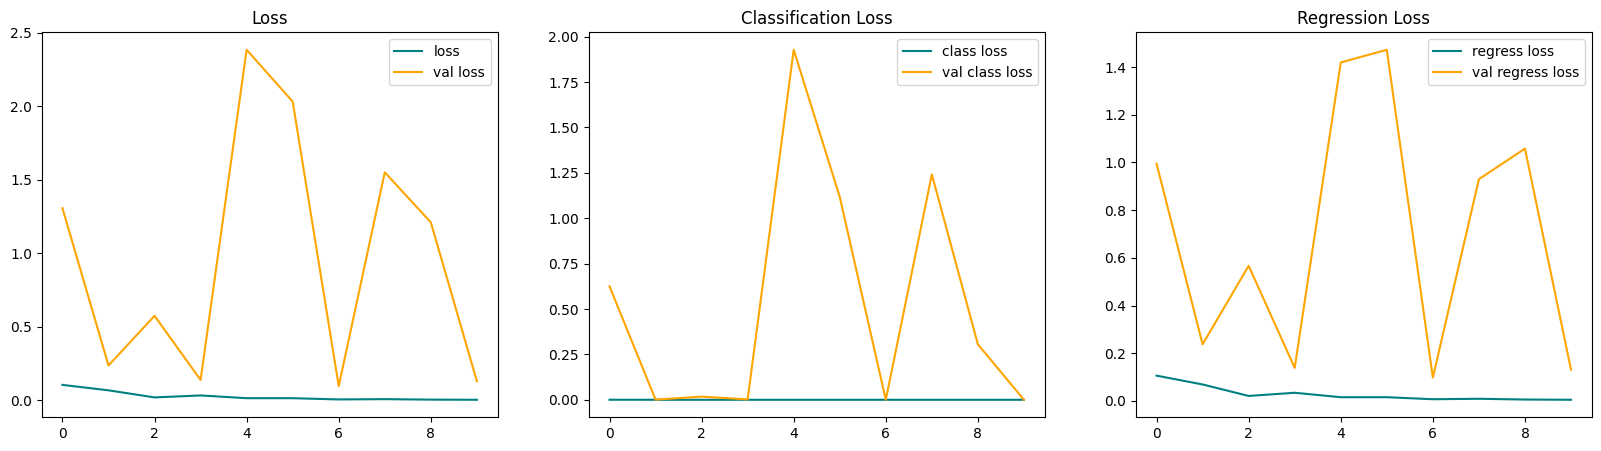

In [115]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [116]:
test_data = test.as_numpy_iterator()

In [117]:
test_sample = test_data.next()

In [118]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 33ms/step


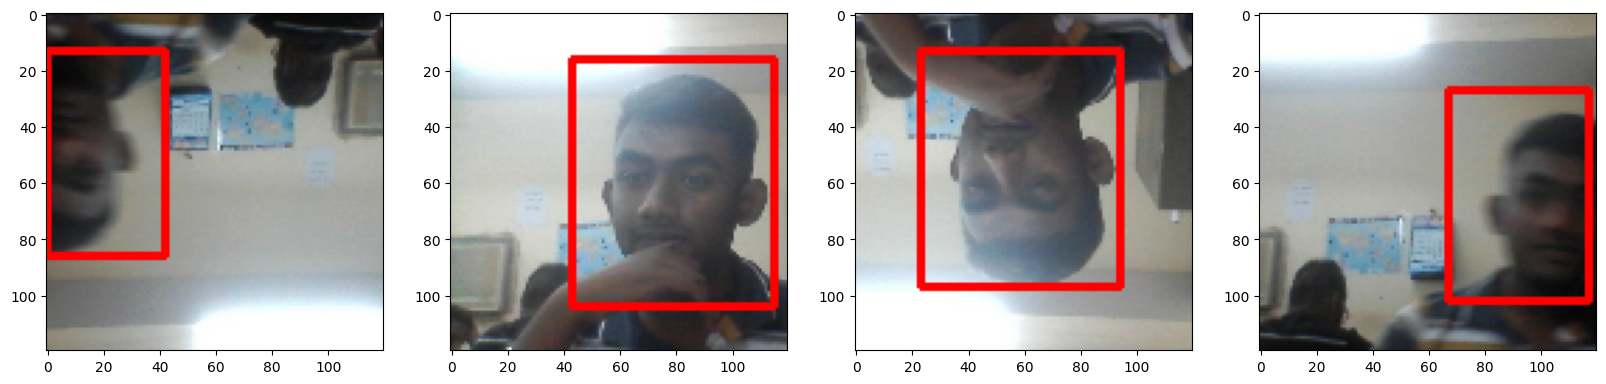

In [120]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [121]:
from tensorflow.keras.models import load_model

In [137]:
facetracker.save('facetracker.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [138]:
facetracker = load_model('facetracker.h5')

11.3 Real Time Detection

In [139]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


In [141]:
import cv2
import numpy as np
import tensorflow as tf

# Load the face tracker model (facetracker) - assuming it's already loaded

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [80, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
